In [7]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import pyodbc as odb
import urllib

In [25]:
import urllib.parse

odb.pooling = False #Turn off pyodbc pooling and use sqlalchemy one

#Create connect-gate to SQL SERVER
url_con = urllib.parse.quote_plus("Driver=ODBC Driver 18 for SQL Server;server=X;database=Northwind;UID=X;PWD=X;TrustServerCertificate=Yes;")
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % url_con)

#Create SQL query to retrive data:
query = """select 
	o1.*
	, o2.UnitPrice, o2.Quantity, o2.Discount
from Orders o1
join OrderDetails o2
on o1.OrderID = o2.OrderID;"""

dtypes = {
    'ShipVia' : 'category',
    'ShipCountry': 'category',
    'ShipCity': 'category',
    'ShipName': 'category',
    'ShipAddress': 'category',
    'OrderID': 'int32',
    'EmployeeID': 'int32',
    'Freight': 'float',
    'UnitPrice': 'float',
    'Quantity' : 'int32',
    'Discount': 'float',
    'CustomerID': 'category',
    'ShipPostalCode': 'category'
}

with engine.connect() as conn:
    order_df_chunk = pd.read_sql(query, conn, 
                           parse_dates={'OrderDate': {"format": "%d/%m/%y"}, 'RequiredDate': {"format": "%d/%m/%y"}, 'ShippedDate': {"format": "%d/%m/%y"}}
                           ,dtype=dtypes ,chunksize=200)
    chunk_item = [chunk for chunk in order_df_chunk]
    order_df = pd.concat(chunk_item, axis=0)

order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2155 entries, 0 to 154
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   OrderID         2155 non-null   int32         
 1   CustomerID      2155 non-null   object        
 2   EmployeeID      2155 non-null   int32         
 3   OrderDate       2155 non-null   datetime64[ns]
 4   RequiredDate    2155 non-null   datetime64[ns]
 5   ShippedDate     2082 non-null   datetime64[ns]
 6   ShipVia         2155 non-null   category      
 7   Freight         2155 non-null   float64       
 8   ShipName        2155 non-null   object        
 9   ShipAddress     2155 non-null   object        
 10  ShipCity        2155 non-null   object        
 11  ShipRegion      856 non-null    object        
 12  ShipPostalCode  2100 non-null   object        
 13  ShipCountry     2155 non-null   object        
 14  UnitPrice       2155 non-null   float64       
 15  Quantity  

In [32]:
#Tinh cac gia tri bo ba R-F-M
from datetime import date
from datetime import timedelta
from datetime import datetime

# Tinh toan so tien chi tieu cua moi kh:
order_df = order_df.assign(total_amount = lambda x: x.Quantity*(x.UnitPrice - x.UnitPrice*x.Discount))
order_df.head()

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,UnitPrice,Quantity,Discount,total_amount
0,10248,VINET,5,2014-07-04 08:00:00,2014-08-01,2014-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France,14.0,12,0.0,168.0
1,10248,VINET,5,2014-07-04 08:00:00,2014-08-01,2014-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France,9.8,10,0.0,98.0
2,10248,VINET,5,2014-07-04 08:00:00,2014-08-01,2014-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France,34.8,5,0.0,174.0
3,10249,TOMSP,6,2014-07-05 04:00:00,2014-08-16,2014-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany,18.6,9,0.0,167.4
4,10249,TOMSP,6,2014-07-05 04:00:00,2014-08-16,2014-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany,42.4,40,0.0,1696.0


In [64]:
max_date = datetime(2016,7,1)

order_df['OrderDate'] = order_df['OrderDate'].apply(lambda x: datetime.strptime(date.strftime(x, "%d-%m-%Y"), "%d-%m-%Y"))

order_df_by_cust = (order_df.groupby('CustomerID')
                    .agg({'CustomerID':'size', 'OrderDate':lambda x: (max_date - x.max()).days,'total_amount':'sum'})
                    .rename({'CustomerID': 'frequency', 'OrderDate':'recency', 'total_amount':'monetary'}, axis = 1))

#Hien thi cac thong so:
order_df_by_cust.head()

,frequency,recency,monetary
CustomerID,,,
ALFKI,12,83,4272.999999
ANATR,10,119,1402.950000
ANTON,17,155,7023.977486
AROUT,30,82,13390.649992
BERGS,52,119,24927.577489


Phan loai nhom KH bang phuong phap KMeans:

In [58]:
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [65]:
#Normalization data:
scaler_ = MinMaxScaler((0, 1))
mod_rfm = scaler_.fit_transform(order_df_by_cust)

k should be 5


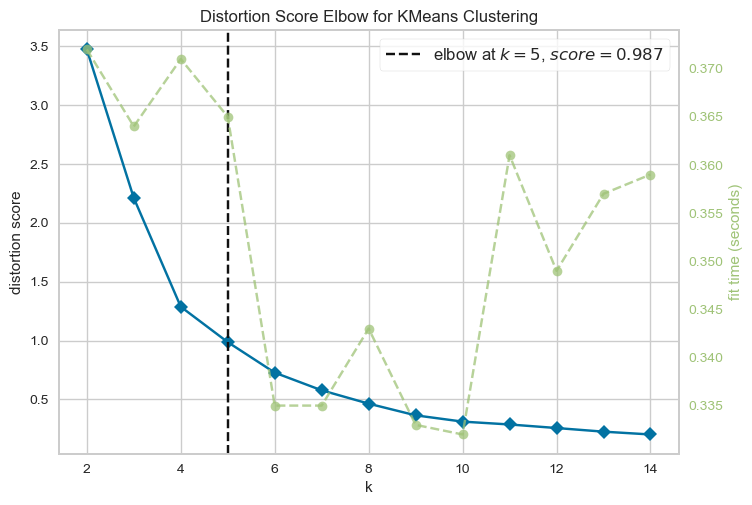

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
#Check elbow point => chon k- cum
kmean_test = KMeans()
elbow_viz = KElbowVisualizer(kmean_test, k=(2, 15))

elbow_viz.fit(mod_rfm)

print(f'k should be {elbow_viz.elbow_value_}')
elbow_viz.show()

In [67]:
import warnings
warnings.filterwarnings('ignore')

#Tien hanh phan cum voi k = 5
kmean_final = KMeans(n_clusters=elbow_viz.elbow_value_).fit(mod_rfm)
kmean_final.cluster_centers_

array([[0.08201754, 0.09183131, 0.03056016],
       [0.87134503, 0.0141844 , 0.96668836],
       [0.20818713, 0.04052685, 0.11748527],
       [0.        , 0.76595745, 0.00116268],
       [0.37155388, 0.03842814, 0.26879172]])

In [68]:
#Gan nhan
order_df_by_cust['KGroupLabels'] = kmean_final.labels_
order_df_by_cust['KGroupLabels'] = order_df_by_cust['KGroupLabels'] + 1

order_df_by_cust.head()

,frequency,recency,monetary,KGroupLabels
CustomerID,,,,
ALFKI,12,83,4272.999999,1
ANATR,10,119,1402.950000,1
ANTON,17,155,7023.977486,1
AROUT,30,82,13390.649992,3
BERGS,52,119,24927.577489,5


In [82]:
# summarize data:
list_numeric = ['frequency', 'recency', 'monetary', 'KGroupLabels']
order_df_by_cust[list_numeric].groupby('KGroupLabels').agg(['min','mean','median','max','count'])

frequency                               recency              \
                   min        mean median  max count     min        mean   
KGroupLabels                                                               
1                    4   11.350000   10.5   20    40      57  116.425000   
2                   86  101.333333  102.0  116     3      57   65.333333   
3                   15   25.733333   25.5   37    30      56   82.666667   
4                    2    2.000000    2.0    2     2     406  560.000000   
5                   32   44.357143   42.0   71    14      56   81.285714   

                                     monetary                                \
             median  max count            min           mean         median   
KGroupLabels                                                                  
1              99.0  297    40     522.500000    3467.811661    3205.980000   
2              61.0   78     3  104361.949868  106607.144368  105182.178354   
3              71.0  171    30    6089.900000   13044.916704   12473.499992   
4             560.0  714     2     100.800000     228.900000     228.900000   
5              64.5  245    14   19261.409976   29715.332688   27010.082219   

                                   
                        max count  
KGroupLabels                       
1              11666.900000    40  
2             110277.304884     3  
3              23128.859954    30  
4                357.000000     2  
5              51097.800488    14

Dựa vào kết quả phân cụm + thống kê mô tả dữ liệu sau phân cụm, ta có:  
1. **Nhóm KH số 2 = Loyal Customer** => Mua gần đây là số lần mua khá nhiều, giá trị giỏ hàng cũng ở mức cao  
2. **Nhóm KH số 5 = Recent Customer** => Số ngày active tính đến thời điểm xét ngang bằng nhóm 1 tuy nhiên số lần mua không cao và giá trị đơn hàng thấp hơn hẳn nhóm 1  
3. **Nhóm KH số 3 = Promising** => Khoảng thời gian nghỉ lâu hơn so với nhóm 2, giá trị giở hàng cũng nhỏ hơn nhóm 2  
4. **Nhóm KH số 1 = At Risk** => Lý do như nhóm số 3, tuy nhiên giá trị giỏ hàng vẫn *trên 1000 USD* => không bị tính là đã out  
5. **Nhóm KH số 4 = Lost** => Khoảng thời gian nghỉ là gần 2 năm so với ngày xét, số lần mua hàng không đáng kể và giá trị giỏ hàng *dưới 500 USD* => Có thể là TH mua trải nghiệm dịch vụ  

In [90]:
# map evaluation standard with RFM label

map_source = {
    1: 'At Risk',
    2: 'Loyal Customers',
    3: 'Promising',
    4: 'Lost',
    5: 'Recent Customers'
}

order_df_by_cust['RFM_Cate'] = order_df_by_cust['KGroupLabels'].map(map_source)
order_df_by_cust.head()

,frequency,recency,monetary,KGroupLabels,RFM_Cate
CustomerID,,,,,
ALFKI,12,83,4272.999999,1,At Risk
ANATR,10,119,1402.950000,1,At Risk
ANTON,17,155,7023.977486,1,At Risk
AROUT,30,82,13390.649992,3,Promising
BERGS,52,119,24927.577489,5,Recent Customers


In [91]:
#Output file => dua vao BI visualization

import os

filename_out = os.getcwd() + '\\RFM_analytics.csv'

order_df_by_cust.to_csv(filename_out)

#Move file into BI folder
to_folder = 'G:\DA_DS tutorial\DA27_classes\Buoi 14_sql\RFM_analytics.csv'

os.rename(filename_out, to_folder)